This notebook decompose the model domain into regions that include the hydraulic flow (strong plunging flow) and other regions in the sills 

In [ ]:
basefile = "/scratch/bcpi/cliu28/internal-tide-mixing"
cd(basefile)
using Interpolations
using NCDatasets
using Oceananigans
using Oceananigans.Units
using NaNStatistics
function deriv(z, y)
    dydz = diff(y[:, :, :, :], dims=3) ./ reshape(diff(z[:]), 1, 1, length(zC) - 1)
    return dydz
end
function calculate_background_buoyancy(θ)
    θ = θ
    ĝ = (sin(θ), 0, cos(θ)) # the vertical unit vector in rotated coordinates
    N = 1e-3
    @inline ẑ(x, z, ĝ) = x * ĝ[1] + z * ĝ[3]
    @inline constant_stratification(x, y, z, t, p) = p.N² * ẑ(x, z, p.ĝ)

    # Create a background field
    B̄_field = BackgroundField(constant_stratification, parameters=(; ĝ, N²=N^2))

    # Setup grid
    H = 2.25kilometers # vertical extent
    Lx = 15kilometers # along-canyon extent
    Ly = 30kilometers # cross-canyon extent
    Nx = 500
    Ny = 1000
    Nz = 250

    # Bottom-intensified stretching for vertical grid
    z_faces(k) = -H * ((1 + ((Nz + 1 - k) / Nz - 1) / 1.2) *
                       (1 - exp(-15 * (Nz + 1 - k) / Nz)) / (1 - exp(-15)) - 1)

    grid = RectilinearGrid(size=(Nx, Ny, Nz),
        x=(0, Lx),
        y=(0, Ly),
        z=z_faces,
        halo=(4, 4, 4),
        topology=(Oceananigans.Periodic, Oceananigans.Periodic, Oceananigans.Bounded))

    model = NonhydrostaticModel(
        grid=grid,
        background_fields=(; b=B̄_field),
        tracers=:b
    )

    return interior(compute!(Field(model.background_fields.tracers.b)))[:, :, :]
end

simname = "tilt"
tᶠ = 460
θ = 3.6e-3
filename_hab = "output/hab.nc"
ds_hab = Dataset(filename_hab, "r")
hab = ds_hab["hab"][:, :, :];
# for mask
filename_verification = string("output/", "tilt", "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", 10, "_threeD_timeavg.nc")
ds_verification = Dataset(filename_verification, "r")
b_ver = ds_verification["b"][:, :, :, 1:1];          # buoyancy perturbation
B̄ = calculate_background_buoyancy(θ)

# define grids
zC = ds_verification["zC"][:];
zF = ds_verification["zF"][:];
Nz = length(zC[:]);

xC = ds_verification["xC"][:];
xF = ds_verification["xF"][:];
Nx = length(xC[:]);
dx = xF[end] - xF[end-1];

yC = ds_verification["yC"][:];
yF = ds_verification["yF"][:];
Ny = length(yC[:]);
dy = yF[end] - yF[end-1];
# t = ds_velocity["time"][:];


data_mode = "10TP average"   # "10TP average" or "tidal phase average"
# data_mode = "tidal phase average"   # "10TP average" or "tidal phase average"

if data_mode == "10TP average"
    filename_velocity = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_timeavg_const_dt_u-v-w-Rig.nc")
    ds_velocity = Dataset(filename_velocity, "r")
    filename_B = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_timeavg_B-c.nc")
    ds_B = Dataset(filename_B, "r")

    what = nanmean(ds_velocity["what"][:, :, :, :], dim=4)    # 10TP average true w
    # Interpolate each row
    what_center = zeros(size(what, 1), size(what, 2), length(zC))
    for i in 1:size(what, 1)
        for j in 1:size(what, 2)
            itp = linear_interpolation(zF[:], what[i, j, :], extrapolation_bc=Line())
            what_center[i, j, :] = itp(zC)
        end
    end
    # Interpolate the magnitude of w: interpolate first then take the time average
    what_mag_center = zeros(size(what_mag, 1), size(what_mag, 2), length(zC))
    what_interp = zeros(size(what, 1), size(what, 2), length(zC))
    for k in 1:size(ds_velocity["what"],4)
        what_t = ds_velocity["what"][:, :, :, k]      # w
        for i in 1:size(what_t, 1)
            for j in 1:size(what_t, 2)
                itp = linear_interpolation(zF[:], what_t[i, j, :], extrapolation_bc=Line())
                what_interp[i, j, :] = itp(zC)
            end
        end
        what_mag_center += abs.(what_interp)          # |w|
    end
    what_mag_center ./= size(ds_velocity["what"], 4)   # time average |w|
    
    B = nanmean(ds_B["B"][:, :, :, :], dim=4)                 # 10TP average B
    Bz = deriv(zC, B)
    Bz[b_ver[:, :, 1:end-1, 1:1].==0] .= 0      # the grids are staggered, but this will effectively set the points inside and right above the immersed boudary to 0
    # interpolate Bz from faces to center cell
    Bz_center = zeros(size(Bz, 1), size(Bz, 2), length(zC))
    for i in 1:size(Bz, 1)
        for j in 1:size(Bz, 2)
            itp = linear_interpolation(zF[2:end-1], Bz[i, j, :], extrapolation_bc=Line())
            Bz_center[i, j, :] = itp(zC)
        end
    end
    b = B .- B̄

elseif data_mode == "tidal phase average"
    filename_velocity = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_u-v-w-c.nc")
    ds_velocity = Dataset(filename_velocity, "r")
    filename_B = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_B-c.nc")
    ds_B = Dataset(filename_B, "r")

    ni = 1:12
    what = zeros(Nx, Ny, Nz + 1, length(ni))
    B = zeros(Nx, Ny, Nz, length(ni))
    for n in 1:length(ni)
        if ni[n] == 1   # first tidal phase
            what[:, :, :, n] = nanmean(ds_velocity["what"][:, :, :, 12:12:120], dim=4)
            B[:, :, :, n] = nanmean(ds_B["B"][:, :, :, 12:12:120], dim=4)
        else            # the rest of the tidal phases
            for i in 1:10
                what[:, :, :, n] += ds_velocity["what"][:, :, :, 12i-(12-(ni[n]-1))]    # true w
                B[:, :, :, n] += ds_B["B"][:, :, :, 12i-(12-(ni[n]-1))]    # true B
            end
            what[:, :, :, n] ./= 10
            B[:, :, :, n] ./= 10
        end
    end
    b = B .- B̄
    b[abs.(b).<1e-15] .= 0
    Bz = deriv(zC, B)
    Bz[b[:, :, 1:end-1, :].==0] .= 0      # the grids are staggered, but this will effectively set the points inside and right above the immersed boudary to 0
    # interpolate Bz from faces to center cell
    Bz_center = zeros(size(Bz, 1), size(Bz, 2), length(zC), length(ni))
    for n in 1:length(ni)
        for i in 1:size(Bz, 1)
            for j in 1:size(Bz, 2)
                itp = linear_interpolation(zF[2:end-1], Bz[i, j, :, n], extrapolation_bc=Line())
                Bz_center[i, j, :, n] = itp(zC)
            end
        end
    end
    # Interpolate each row
    what_center = zeros(size(what, 1), size(what, 2), length(zC), length(ni))
    for n in 1:length(ni)
        for i in 1:size(what, 1)
            for j in 1:size(what, 2)
                itp = linear_interpolation(zF[:], what[i, j, :, n], extrapolation_bc=Line())
                what_center[i, j, :, n] = itp(zC)
            end
        end
    end
end



# Define dimensions based on the data mode
if data_mode == "10TP average"
    # save the data into netcdf file including what_center and Bz_center
    output_filename = string("output/", simname, "/10TP_average_w_Bz_theta=", θ, "_tᶠ=", tᶠ, ".nc")
    # Check if file exists and remove it if it does
    if isfile(output_filename)
        rm(output_filename)
        println("Removed existing file: $output_filename")
    end
    # Create a new NetCDF file
    ds_output = Dataset(output_filename, "c")
    # Define dimensions
    defDim(ds_output, "x", Nx)
    defDim(ds_output, "y", Ny)
    defDim(ds_output, "z", Nz)

    # Define variables
    v_what = defVar(ds_output, "what_center", Float64, ("x", "y", "z"))
    v_what_mag = defVar(ds_output, "what_mag_center", Float64, ("x", "y", "z"))
    v_Bz = defVar(ds_output, "Bz_center", Float64, ("x", "y", "z"))
    v_b = defVar(ds_output, "b", Float64, ("x", "y", "z"))

    # Write data
    v_what[:, :, :] = what_center
    v_what_mag[:, :, :] = what_mag_center
    v_Bz[:, :, :] = Bz_center
    v_b[:, :, :] = b

elseif data_mode == "tidal phase average"
    output_filename = string("output/", simname, "/tidal_phase_average_w_Bz_theta=", θ, "_tᶠ=", tᶠ, ".nc")
    # Check if file exists and remove it if it does
    if isfile(output_filename)
        rm(output_filename)
        println("Removed existing file: $output_filename")
    end
    # Create a new NetCDF file
    ds_output = Dataset(output_filename, "c")
    # Define dimensions
    defDim(ds_output, "x", Nx)
    defDim(ds_output, "y", Ny)
    defDim(ds_output, "z", Nz)
    defDim(ds_output, "tidal_phase", length(ni))

    # Define variables
    v_what = defVar(ds_output, "what_center", Float64, ("x", "y", "z", "tidal_phase"))
    v_Bz = defVar(ds_output, "Bz_center", Float64, ("x", "y", "z", "tidal_phase"))

    # Write data
    v_what[:, :, :, :] = what_center
    v_Bz[:, :, :, :] = Bz_center

    # Add tidal phase information
    v_phase = defVar(ds_output, "tidal_phase", Int32, ("tidal_phase",))
    v_phase[:] = ni
end

# Add grid variables
v_xC = defVar(ds_output, "xC", Float64, ("x",))
v_yC = defVar(ds_output, "yC", Float64, ("y",))
v_zC = defVar(ds_output, "zC", Float64, ("z",))
v_xC[:] = xC
v_yC[:] = yC
v_zC[:] = zC

# Add global attributes
ds_output.attrib["data_mode"] = data_mode
ds_output.attrib["simulation"] = simname
ds_output.attrib["theta"] = θ
ds_output.attrib["tf"] = tᶠ

# Close the file
close(ds_output)
println("Data saved to: $output_filename")



Load bathymetry

In [1]:
# load topography 
Nx = 500
Ny = 1000
Nz = 250
basefile = "/scratch/bcpi/cliu28/internal-tide-mixing"
cd(basefile)
using MAT
using Interpolations
file = matopen("topo.mat")
z_topo = read(file, "z_noslope_periodic")
x_topo = read(file, "x_domain")
y_topo = read(file, "y_domain")
# grids has to be evenly spaced
x_topo_lin = range(x_topo[1], x_topo[end], size(z_topo, 1))
y_topo_lin = range(y_topo[1], y_topo[end], size(z_topo, 2))
close(file)
# high-resolution grids
x_interp = range(x_topo[1], x_topo[end], length=Nx)
y_interp = range(y_topo[1], y_topo[end], length=Ny)


# Interpolation object (caches coefficients and such)
itp = LinearInterpolation((x_topo_lin, y_topo_lin), z_topo)
# Interpolate z_topo onto a higher-resolution grid
z_interp = [itp(x, y) for x in x_interp, y in y_interp]
z_interp = z_interp .- minimum(z_interp)

500×1000 Matrix{Float64}:
 1108.12  1109.76  1111.41  1113.05  …  1108.96  1108.68  1108.4   1108.12
 1113.52  1115.1   1116.68  1118.27     1114.41  1114.11  1113.82  1113.52
 1118.92  1120.44  1121.96  1123.48     1119.85  1119.54  1119.23  1118.92
 1124.32  1125.78  1127.24  1128.7      1125.3   1124.97  1124.64  1124.32
 1129.71  1131.12  1132.52  1133.92     1130.74  1130.4   1130.06  1129.71
 1135.11  1136.45  1137.8   1139.14  …  1136.18  1135.83  1135.47  1135.11
 1140.51  1141.79  1143.07  1144.36     1141.63  1141.25  1140.88  1140.51
 1145.91  1147.13  1148.35  1149.57     1147.07  1146.68  1146.3   1145.91
 1151.31  1152.47  1153.63  1154.79     1152.51  1152.11  1151.71  1151.31
 1156.7   1157.81  1158.91  1160.01     1157.96  1157.54  1157.12  1156.7
    ⋮                                ⋱                             
 1108.97  1110.4   1111.83  1113.26     1109.82  1109.53  1109.25  1108.97
 1108.86  1110.32  1111.78  1113.24     1109.71  1109.43  1109.14  1108.86
 1108.7

Decompose model domain into three different regions, define masks

In [2]:
function create_masks(data_mode="10TP average"; sill_height_threshold=300, high_sill_threshold=830, part=1)
    # Create a mask for elevated bathymetry in the central region
    mask_bathymetry = zeros(Int, size(z_interp))
    mask_bathymetry[z_interp.>sill_height_threshold] .= 1
    mask_bathymetry[:, 18Ny÷30:Ny] .= 0
    mask_bathymetry[:, 1:7Ny÷30] .= 0

    # Create downwelling mask based on vertical velocity
    if data_mode == "10TP average"
        filename_velocity = "output/tilt/10TP_average_w_Bz_theta=0.0036_tᶠ=460.nc"
        ds = Dataset(filename_velocity, "r")
        # Read the vertical velocity data
        what_center = ds["what_center"][:, :, :]
        mask_downwelling = zeros(Int, size(z_interp))
        # Check each water column
        for i in 1:Nx
            for j in 1:Ny
                # If any point in the column meets the condition
                if any(what_center[i, j, :] .< -1e-2)
                    # Mark the entire column
                    mask_downwelling[i, j] = 1
                end
            end
        end
        
        # Combine both masks - sill is where we have both high bathymetry and strong downwelling
        mask_sill = mask_downwelling .* mask_bathymetry
    else
        # filename_velocity = "output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc"
        filename_velocity = string("output/tilt/tidal_phase_average_w_Bz_theta=", θ, "_tᶠ=460_part-", part, ".nc")

        ds = Dataset(filename_velocity, "r")
        what_center = ds["what_center"][:, :, :, :]
        mask_downwelling = zeros(Int, Nx, Ny, length(ds["tidal_phase"][:]))
        # For tidal phase average, create masks for each phase
        for l in 1:length(ds["tidal_phase"][:])
            for i in 1:Nx
                for j in 1:Ny
                    # If any point in the column meets the condition
                    if any(what_center[i, j, :, l] .< -1e-2)
                        # Mark the entire column
                        mask_downwelling[i, j, l] = 1
                    end
                end
            end
            @info l
        end
        
        # For tidal phase average, apply bathymetry mask to each phase
        mask_sill = zeros(Int, size(mask_downwelling))
        for l in 1:size(mask_downwelling, 3)
            mask_sill[:, :, l] = mask_downwelling[:, :, l] .* mask_bathymetry
        end
    end

    ## Create separate masks for the north and south sills
    mask_sill_bathymetry = zeros(Int, size(z_interp))
    mask_sill_bathymetry[z_interp.>high_sill_threshold] .= 1

    mask_north_bathymetry = copy(mask_sill_bathymetry)
    mask_north_bathymetry[:, 1:18Ny÷30] .= 0
    mask_south_bathymetry = copy(mask_sill_bathymetry)
    mask_south_bathymetry[:, Ny÷3:Ny] .= 0
    
    return mask_sill, mask_north_bathymetry, mask_south_bathymetry
end

create_masks (generic function with 2 methods)

Plot the regions of the three masks

┌ Info: 1
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:44
┌ Info: 2
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:44
┌ Info: 3
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:44
┌ Info: 4
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:44


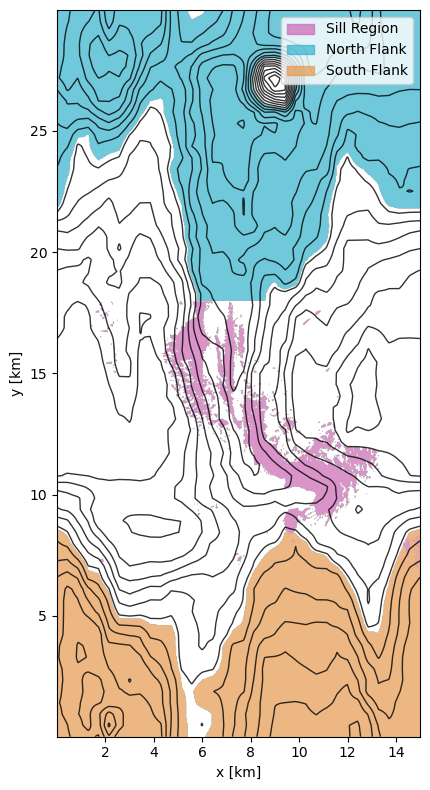

In [ ]:
# Import plotting package
ds = Dataset("output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc", "r")
xC = ds["xC"][:];
yC = ds["yC"][:];
# Call the function to create masks based on the desired data mode
data_mode = "tidal phase average"   # "10TP average" or "tidal phase average"
mask_sill, mask_north_bathymetry, mask_south_bathymetry = create_masks(data_mode; part=1)

using PyPlot

# Create a combined mask to visualize the three regions
combined_mask = zeros(Int, Nx, Ny)

# For 3D masks, take the maximum value along the vertical direction
sill_2d = mask_sill[:, :, 1]

# Combine the masks - ensuring the sill takes precedence
combined_mask[sill_2d.==1] .= 1
combined_mask[(sill_2d.==0).&(mask_north_bathymetry.==1)] .= 2
combined_mask[(sill_2d.==0).&(mask_south_bathymetry.==1)] .= 3
# Convert to floating point before assigning NaN
combined_mask = Float64.(combined_mask)
combined_mask[combined_mask.==0] .= NaN

fig, ax = subplots(figsize=(10, 8))

# Define a custom colormap for the regions
# Define a custom colormap with nicer colors and transparency
region_colors = [
    (0.8, 0.4, 0.7, 0.7),        # Soft purple for sill region
    (0.2, 0.7, 0.8, 0.7),        # Teal for North Flank
    (0.9, 0.6, 0.3, 0.7)         # Amber for South Flank
]
cmap = matplotlib.colors.ListedColormap(region_colors)
bounds = [1, 2, 3, 4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the mask
im = ax.imshow(combined_mask', origin="lower", extent=[xC[1], xC[end], yC[1], yC[end]] ./ 1e3,
    aspect="equal", cmap=cmap, norm=norm)

# Add bathymetry contours
contours = ax.contour(xC / 1e3, yC / 1e3, z_interp', 0:100:2200, colors="black", alpha=0.8, linewidths=1)

# Create custom legend
region_labels = ["Sill Region", "North Flank", "South Flank"]
patches = [matplotlib.patches.Patch(color=region_colors[i], label=region_labels[i]) for i in 1:3]
ax.legend(handles=patches, loc="upper right")

# Add labels and title
# ax.set_title("Domain Region Decomposition")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")

tight_layout()
display(gcf())


Compute the hab average for each regions

In [50]:
using NCDatasets
using PyPlot
include("../functions/bins.jl")
# load hab
filename_hab = "output/hab.nc"
ds_hab = Dataset(filename_hab, "r")
hab = ds_hab["hab"][:, :, :];
bin_mask = hab;
θ = 0.0036
dx = 30
dy = 30
# Define the bin edges
bin_edge = 0:7:1500
bin_center = @. (bin_edge[1:end-1] + bin_edge[2:end]) / 2
# data_mode = "tidal phase average"   # "10TP average" or "tidal phase average"
data_mode = "10TP average"   # "10TP average" or "tidal phase average"
if data_mode == "10TP average"
    filename_velocity = "output/tilt/10TP_average_w_Bz_theta=0.0036_tᶠ=460.nc"
    ds = Dataset(filename_velocity, "r")
    # Read the vertical velocity data
    what_center = ds["what_center"][:, :, :]
    Bz_center = ds["Bz_center"][:, :, :]
else
    filename_velocity = "output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc"
    ds = Dataset(filename_velocity, "r")
    what_center = ds["what_center"][:, :, :, :]
    Bz_center = ds["Bz_center"][:, :, :, :]
end
filename_verification = string("output/", "tilt", "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", 10, "_threeD_timeavg.nc")
ds_verification = Dataset(filename_verification, "r")
zF = ds_verification["zF"][:];

# Convert the masks to Float64 before assigning NaN values
mask_withsill = Float64.(mask_sill)
mask_withsill[mask_withsill.==0] .= NaN

mask_withoutsill = Float64.(mask_sill)
mask_withoutsill[mask_withoutsill.==1] .= NaN
mask_withoutsill[mask_withoutsill.==0] .= 1

mask_north_bathymetry = Float64.(mask_north_bathymetry)
mask_north_bathymetry[mask_north_bathymetry.==0] .= NaN

mask_south_bathymetry = Float64.(mask_south_bathymetry)
mask_south_bathymetry[mask_south_bathymetry.==0] .= NaN

@time Bz_total_avg, _ = bins(Bz_center, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_total_avg, _ = bins(what_center, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
if data_mode == "tidal phase average"
    mask_sill_reshaped = reshape(mask_withsill, size(mask_withsill, 1), size(mask_withsill, 2), 1, size(mask_withsill, 3))
else
    mask_sill_reshaped = mask_withsill
end

@time Bz_withoutsill_avg, _ = bins(Bz_center .* mask_withoutsill, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_withoutsill_avg, _ = bins(what_center .* mask_withoutsill, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time Bz_sill_avg, _ = bins(Bz_center .* mask_sill_reshaped, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_sill_avg, _ = bins(what_center .* mask_sill_reshaped, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time Bz_north_avg, _ = bins(Bz_center .* mask_north_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_north_avg, _ = bins(what_center .* mask_north_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time Bz_south_avg, _ = bins(Bz_center .* mask_south_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_south_avg, _ = bins(what_center .* mask_south_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)

  6.743138 seconds (791.37 k allocations: 4.750 GiB, 10.19% gc time, 21.90% compilation time)
  4.879282 seconds (62 allocations: 4.700 GiB, 16.54% gc time)
  5.684173 seconds (65 allocations: 5.568 GiB, 12.43% gc time)
  5.606561 seconds (65 allocations: 5.568 GiB, 15.85% gc time)
  2.637186 seconds (65 allocations: 3.556 GiB, 28.41% gc time)
  2.451884 seconds (65 allocations: 3.556 GiB, 24.70% gc time)
  3.178257 seconds (65 allocations: 3.899 GiB, 22.07% gc time)
  3.385315 seconds (65 allocations: 3.899 GiB, 21.79% gc time)
  3.091639 seconds (65 allocations: 3.794 GiB, 24.14% gc time)
  2.995055 seconds (65 allocations: 3.794 GiB, 26.65% gc time)


([-0.0010488479196775877; -0.0017737072664579755; … ; 0.0; 0.0;;], 3.5:7.0:1494.5)

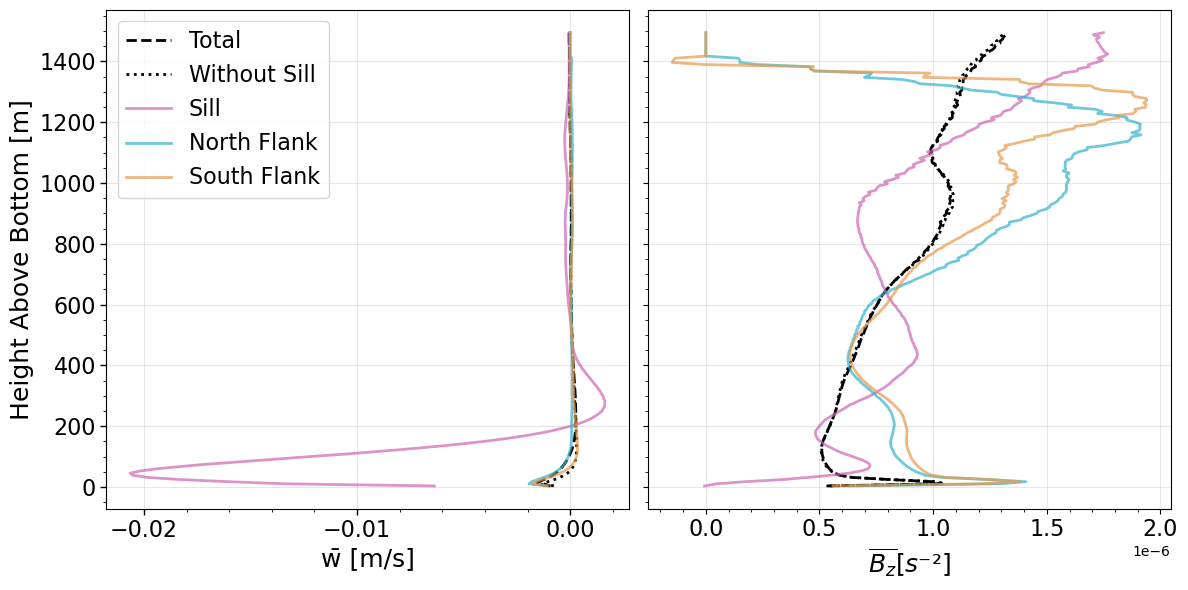

In [54]:
if data_mode == "10TP average"
    # Create figure with two subplots
    region_colors = [
        (0.8, 0.4, 0.7, 0.7),        # Soft purple for sill region
        (0.2, 0.7, 0.8, 0.7),        # Teal for North Flank
        (0.9, 0.6, 0.3, 0.7)         # Amber for South Flank
    ]
    close("all")
    fig, ax = PyPlot.subplots(1, 2, figsize=(12, 6), sharey=true)

    # Plot vertical velocity (w)
    ax[1].plot(w_total_avg, bin_center, label="Total", linewidth=2, color="black", linestyle="--")
    ax[1].plot(w_withoutsill_avg, bin_center, label="Without Sill", linewidth=2, color="black", linestyle=":")
    ax[1].plot(w_sill_avg, bin_center, label="Sill", linewidth=2, color=region_colors[1])
    ax[1].plot(w_north_avg, bin_center, label="North Flank", linewidth=2, color=region_colors[2])
    ax[1].plot(w_south_avg, bin_center, label="South Flank", linewidth=2, color=region_colors[3])
    ax[1].set_xlabel("w̄ [m/s]", fontsize=18)
    ax[1].set_ylabel("Height Above Bottom [m]", fontsize=18)
    ax[1].grid(true, alpha=0.3)
    ax[1].tick_params(axis="both", which="major", labelsize=16)
    ax[1].set_xticks(-0.02:0.01:0.005)  # Fewer ticks
    ax[1].minorticks_on()  # Enable minor ticks
    ax[1].tick_params(axis="both", which="major", length=4, width=1, color="black", direction="out")
    # Plot vertical buoyancy gradient (Bz)
    ax[2].plot(Bz_total_avg, bin_center, label="Total", linewidth=2, color="black", linestyle="--")
    ax[2].plot(Bz_withoutsill_avg, bin_center, label="Without Sill", linewidth=2, color="black", linestyle=":")
    ax[2].plot(Bz_sill_avg, bin_center, label="Sill", linewidth=2, color=region_colors[1])
    ax[2].plot(Bz_north_avg, bin_center, label="North Flank", linewidth=2, color=region_colors[2])
    ax[2].plot(Bz_south_avg, bin_center, label="South Flank", linewidth=2, color=region_colors[3])
    ax[2].set_xlabel(L"\overline{B_z} [s⁻²]", fontsize=18)
    # axes[2].set_title("Vertical Buoyancy Gradient", fontsize=20)
    ax[2].grid(true, alpha=0.3)
    ax[2].minorticks_on()  # Enable minor ticks
    ax[2].tick_params(axis="both", which="major", labelsize=16)
    ax[1].legend(fontsize=16)

    tight_layout()
    display(gcf())
end

Plot tidal phase average at each regions. Soft to strong colors indicates tidal phase 1/12, 4/12, 7/12, and 10/12

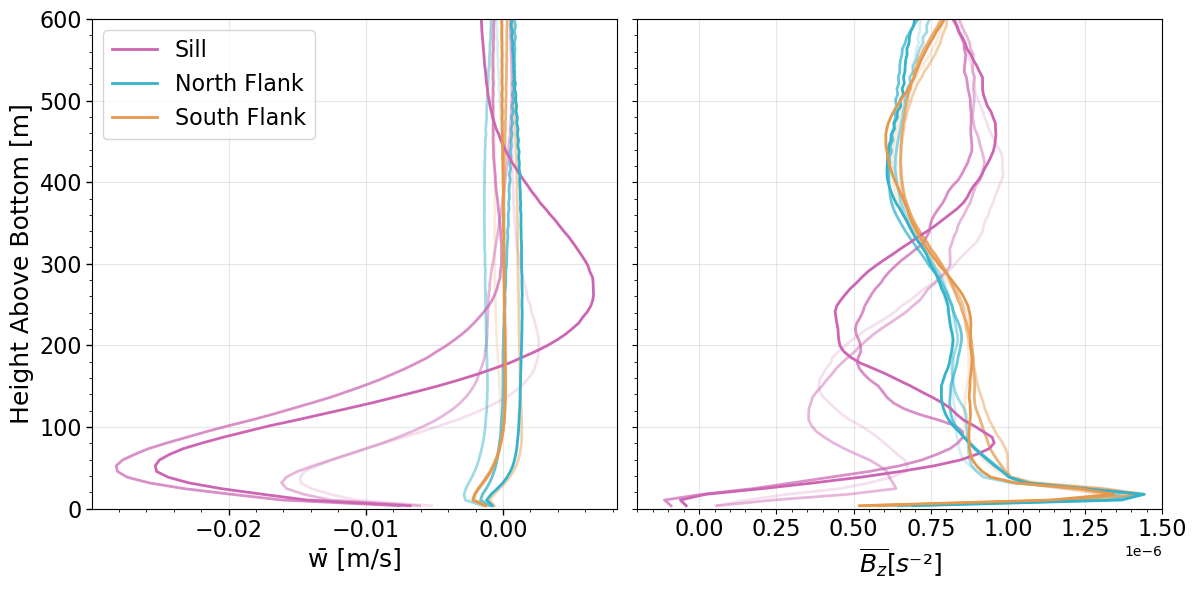

In [ ]:
using PyPlot 
if data_mode == "tidal phase average"
    # Create figure with two subplots
    region_colors = [
        (0.8, 0.4, 0.7),        # Base purple for sill region
        (0.2, 0.7, 0.8),        # Base teal for North Flank
        (0.9, 0.6, 0.3)         # Base amber for South Flank
    ]
    n_times = size(w_sill_avg, 2)
    alphas = range(0.2, 1.0, length=n_times)  # From soft to strong

    fig, ax = PyPlot.subplots(1, 2, figsize=(12, 6), sharey=true)

    # Plot w profiles for each region and time
    for t in 1:n_times
        ax[1].plot(w_sill_avg[:, t], bin_center, color=region_colors[1], alpha=alphas[t], linewidth=2, label=t==n_times ? "Sill" : "")
        ax[1].plot(w_north_avg[:, t], bin_center, color=region_colors[2], alpha=alphas[t], linewidth=2, label=t==n_times ? "North Flank" : "")
        ax[1].plot(w_south_avg[:, t], bin_center, color=region_colors[3], alpha=alphas[t], linewidth=2, label=t==n_times ? "South Flank" : "")
    end
    ax[1].set_xlabel("w̄ [m/s]", fontsize=18)
    ax[1].set_ylabel("Height Above Bottom [m]", fontsize=18)
    ax[1].grid(true, alpha=0.3)
    ax[1].tick_params(axis="both", which="major", labelsize=16)
    ax[1].set_xticks(-0.02:0.01:0.005)
    ax[1].minorticks_on()
    ax[1].tick_params(axis="both", which="major", length=4, width=1, color="black", direction="out")
    ax[1].legend(fontsize=16)
    ax[1].set_ylim(0,600)

    # Plot Bz profiles for each region and time
    for t in 1:n_times
        ax[2].plot(Bz_sill_avg[:, t], bin_center, color=region_colors[1], alpha=alphas[t], linewidth=2, label=t==n_times ? "Sill" : "")
        ax[2].plot(Bz_north_avg[:, t], bin_center, color=region_colors[2], alpha=alphas[t], linewidth=2, label=t==n_times ? "North Flank" : "")
        ax[2].plot(Bz_south_avg[:, t], bin_center, color=region_colors[3], alpha=alphas[t], linewidth=2, label=t==n_times ? "South Flank" : "")
    end
    ax[2].set_xlabel(L"\overline{B_z} [s⁻²]", fontsize=18)
    ax[2].grid(true, alpha=0.3)
    ax[2].minorticks_on()
    ax[2].tick_params(axis="both", which="major", labelsize=16)
    ax[2].set_ylim(0,600)
    ax[2].set_xlim(-0.2e-6,1.5e-6)
    tight_layout()
    display(gcf())
end

It is possible that the downwelling and upwelling in the same region canceled out each other when taking hab averages. Thus, the tidal magnitude would be more useful, which is defined as: $$\mathcal{A}=\frac{\left<\bar{a}(x,y,hab)\right>_{hab}}{\left<\overline{|w|}^t(x,y,hab)\right>}_{hab}$$, where $\bar{a}$ is the tidal amplitude, defined as the difference between maximum and minimum values of the tidal phase average vertical velocity, $\bar{w}$. The denominator is the 10 tidal period average vertical velocity. This nondimensional number reveals that whether the vertical velocity variation is dominated by tide ($\mathcal{A}>>1$) or it is something else ($\mathcal{A}\sim1$).
Seperating hab averages in the numerator and denominator helps smooth out the curves.

In [3]:
basefile = "/scratch/bcpi/cliu28/internal-tide-mixing"
cd(basefile)

using NCDatasets
using PyPlot
using NaNStatistics
using Statistics
include("../functions/bin_stat_over_xy.jl")

# load hab
filename_hab = "output/hab.nc"
ds_hab = Dataset(filename_hab, "r")
hab = ds_hab["hab"][:, :, :];
bin_var = hab;
θ = 0.0036
dx = 30
dy = 30
# Define the bin edges
bin_edge = 0:7:1500
bin_center = @. (bin_edge[1:end-1] + bin_edge[2:end]) / 2

# Load 10TP average data
filename_velocity = "output/tilt/10TP_average_w_Bz_theta=0.0036_tᶠ=460.nc"
ds = Dataset(filename_velocity, "r")
what_mag_center_10TP = ds["what_mag_center"][:, :, :]

# Create masks for different regions
mask_sill, mask_north_bathymetry, mask_south_bathymetry = create_masks("10TP average")
mask_sill_flanks = mask_north_bathymetry .+ mask_south_bathymetry
mask_rest = (1 .- mask_sill) .* (1 .- mask_north_bathymetry) .* (1 .- mask_south_bathymetry)

# Apply masks to 10TP data
what_sill_10TP = what_mag_center_10TP .* mask_sill
what_flanks_10TP = what_mag_center_10TP .* mask_sill_flanks
what_rest_10TP = what_mag_center_10TP .* mask_rest

# Process tidal phase data in a memory-efficient way
# Create arrays to store max and min values
max_sill = zeros(size(what_mag_center_10TP))
min_sill = zeros(size(what_mag_center_10TP))
max_flanks = zeros(size(what_mag_center_10TP))
min_flanks = zeros(size(what_mag_center_10TP))
max_rest = zeros(size(what_mag_center_10TP))
min_rest = zeros(size(what_mag_center_10TP))

# Initialize with opposite extremes
min_sill .= Inf
min_flanks .= Inf
min_rest .= Inf
max_sill .= -Inf
max_flanks .= -Inf
max_rest .= -Inf

# Process part 1
println("Processing part 1...")
filename_velocity1 = "output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460_part-1.nc"
ds1 = Dataset(filename_velocity1, "r")
mask_sill_tidal_phase1, mask_north_flanks1, mask_south_flanks1 = create_masks("tidal phase average"; part=1)
mask_flanks1 = mask_north_flanks1 .+ mask_south_flanks1
mask_rest1 = (1 .- mask_sill_tidal_phase1) .* (1 .- mask_north_flanks1) .* (1 .- mask_south_flanks1)

# Process each time step to save memory
for t in 1:size(ds1["what_center"], 4)
    what_t = ds1["what_center"][:,:,:,t]
    
    # Apply masks for current time step
    what_sill_t = what_t .* mask_sill_tidal_phase1[:,:,t]
    what_flanks_t = what_t .* mask_flanks1
    what_rest_t = what_t .* mask_rest1[:,:,t]
    
    # Update max and min
    max_sill = max.(max_sill, what_sill_t)
    min_sill = min.(min_sill, what_sill_t)
    max_flanks = max.(max_flanks, what_flanks_t)
    min_flanks = min.(min_flanks, what_flanks_t)
    max_rest = max.(max_rest, what_rest_t)
    min_rest = min.(min_rest, what_rest_t)
    @info t
end
close(ds1)

# Process part 2
println("Processing part 2...")
filename_velocity2 = "output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460_part-2.nc"
ds2 = Dataset(filename_velocity2, "r")
mask_sill_tidal_phase2, mask_north_flanks2, mask_south_flanks2 = create_masks("tidal phase average"; part=2)
mask_flanks2 = mask_north_flanks2 .+ mask_south_flanks2
mask_rest2 = (1 .- mask_sill_tidal_phase2) .* (1 .- mask_north_flanks2) .* (1 .- mask_south_flanks2)

# Process each time step
for t in 1:size(ds2["what_center"], 4)
    what_t = ds2["what_center"][:,:,:,t]
    
    # Apply masks for current time step
    what_sill_t = what_t .* mask_sill_tidal_phase2[:,:,t]
    what_flanks_t = what_t .* mask_flanks2  
    what_rest_t = what_t .* mask_rest2[:,:,t] 
    
    # Update max and min
    max_sill = max.(max_sill, what_sill_t)
    min_sill = min.(min_sill, what_sill_t)
    max_flanks = max.(max_flanks, what_flanks_t)
    min_flanks = min.(min_flanks, what_flanks_t)
    max_rest = max.(max_rest, what_rest_t)
    min_rest = min.(min_rest, what_rest_t)
    @info t
end
close(ds2)

# Calculate tidal amplitudes
ā_sill = max_sill .- min_sill
ā_flanks = max_flanks .- min_flanks
ā_rest = max_rest .- min_rest

# Set zeros to NaN to avoid division issues
what_sill_10TP[what_sill_10TP.==0] .= NaN
what_flanks_10TP[what_flanks_10TP.==0] .= NaN
what_rest_10TP[what_rest_10TP.==0] .= NaN
ā_sill[ā_sill.==0] .= NaN
ā_flanks[ā_flanks.==0] .= NaN
ā_rest[ā_rest.==0] .= NaN

# Calculate tidal magnitude for each point
A_sill = ā_sill ./ what_sill_10TP
A_flanks = ā_flanks ./ what_flanks_10TP
A_rest = ā_rest ./ what_rest_10TP

# Calculate HAB averages
A_sill_seperate_hab = bin_stat_over_xy(ā_sill, bin_edge, bin_var; stat="mean") ./ 
                      bin_stat_over_xy(what_sill_10TP, bin_edge, bin_var; stat="mean")
A_flanks_seperate_hab = bin_stat_over_xy(ā_flanks, bin_edge, bin_var; stat="mean") ./ 
                        bin_stat_over_xy(what_flanks_10TP, bin_edge, bin_var; stat="mean")
A_rest_seperate_hab = bin_stat_over_xy(ā_rest, bin_edge, bin_var; stat="mean") ./ 
                      bin_stat_over_xy(what_rest_10TP, bin_edge, bin_var; stat="mean")

# Also calculate amplitude HAB averages
A_sill_hab = bin_stat_over_xy(ā_sill./what_sill_10TP, bin_edge, bin_var; stat="mean")
A_flanks_hab = bin_stat_over_xy(ā_flanks./what_flanks_10TP, bin_edge, bin_var; stat="mean")
A_rest_hab = bin_stat_over_xy(ā_rest./what_rest_10TP, bin_edge, bin_var; stat="mean")

println("Processing complete!")

Processing part 1...


┌ Info: 1
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 2
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 3
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 4
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 5
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 6
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 1
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebo

Processing part 2...


┌ Info: 1
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 2
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 3
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 4
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 5
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 6
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: 1
└ @ Main /scratch/bcpi/cliu28/internal-tide-mixing/postprocess/jl_notebo

Processing complete!


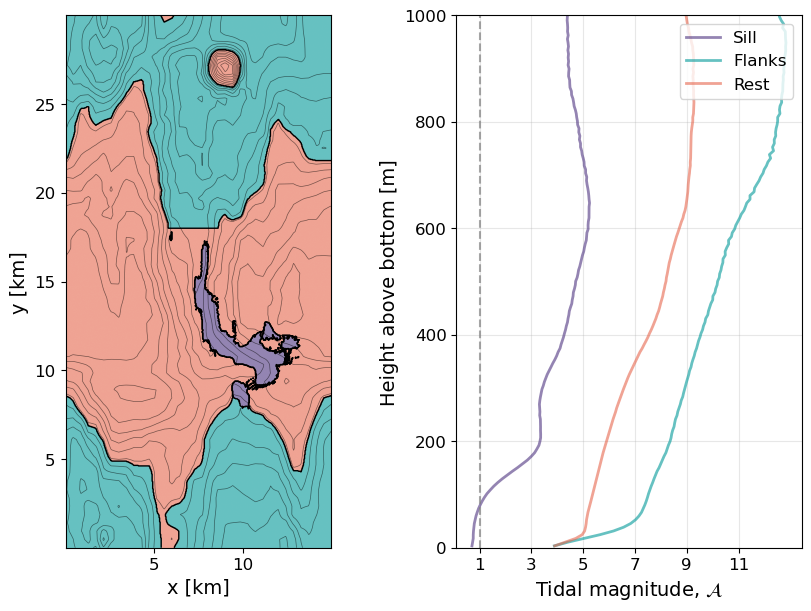

In [8]:
# Import plotting package
ds = Dataset("output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460_part-1.nc", "r")
xC = ds["xC"][:];
yC = ds["yC"][:];
# Call the function to create masks based on the desired data mode
data_mode = "10TP average"   # "10TP average" or "tidal phase average"
mask_sill, mask_north_bathymetry, mask_south_bathymetry = create_masks(data_mode)

using PyPlot

# Define region colors to match previous plots
region_colors = [
    (0.3, 0.2, 0.5, 0.6),  # Rich indigo for sill region
    (0.0, 0.6, 0.6, 0.6),  # Turquoise for Flanks
    (0.9, 0.4, 0.3, 0.6)   # Coral red for Rest of domain
]

# Create a figure with two subplots side by side, with the map on the left
fig, (ax_map, ax_profile) = subplots(1, 2, figsize=(8, 6), constrained_layout=true)

# --- Topographic map (left) ---
# Create a combined mask for the topographic map
combined_mask = zeros(Float64, Nx, Ny)
mask_sill_2d = mask_sill[:, :, 1] # For tidal phase average use first phase
combined_mask[mask_sill_2d .== 1] .= 1
combined_mask[(mask_sill_2d .== 0) .& ((mask_north_bathymetry .+ mask_south_bathymetry) .> 0)] .= 2
combined_mask[(mask_sill_2d .== 0) .& ((mask_north_bathymetry .+ mask_south_bathymetry) .== 0)] .= 3
combined_mask[combined_mask .== 0] .= NaN

# Create a custom colormap with the same colors as the line plot
region_cmap = matplotlib.colors.ListedColormap([region_colors[1], region_colors[2], region_colors[3]])
bounds = [0.5, 1.5, 2.5, 3.5]
norm = matplotlib.colors.BoundaryNorm(bounds, region_cmap.N)

# Plot the topographic map with correct aspect ratio
im = ax_map.imshow(
    combined_mask', 
    origin="lower", 
    extent=[xC[1], xC[end], yC[1], yC[end]] ./ 1e3,
    aspect="equal",  # Ensures 1:1 aspect ratio in km
    cmap=region_cmap, 
    norm=norm
)
ax_map.contour(
    xC / 1e3, yC / 1e3, combined_mask', 
    levels=[1.5, 2.5], colors="black", linewidths=1.0
)

# Add bathymetry contours
contours = ax_map.contour(
    xC / 1e3, yC / 1e3, z_interp', 
    0:100:2200, colors="black", alpha=0.5, linewidths=0.5
)

# Create patches for legend
patches = [matplotlib.patches.Patch(color=region_colors[i]) 
           for i in 1:3]
# ax_map.legend(handles=patches, loc="upper right", fontsize=12)

# Add labels
ax_map.set_xlabel("x [km]", fontsize=14)
ax_map.set_ylabel("y [km]", fontsize=14)
# ax_map.set_title("Domain Regions", fontsize=14)
ax_map.tick_params(axis="both", which="major", labelsize=12)

# --- Tidal magnitude profile (right) ---
ax_profile.plot(A_sill_seperate_hab, bin_center, label="Sill", linewidth=2, color=region_colors[1])
ax_profile.plot(A_flanks_seperate_hab, bin_center, label="Flanks", linewidth=2, color=region_colors[2])
ax_profile.plot(A_rest_seperate_hab, bin_center, label="Rest", linewidth=2, color=region_colors[3])
# ax_profile.plot(A_sill_hab, bin_center, label="Sill", linewidth=2, color=region_colors[1])
# ax_profile.plot(A_flanks_hab, bin_center, label="Flanks", linewidth=2, color=region_colors[2])
# ax_profile.plot(A_rest_hab, bin_center, label="Rest", linewidth=2, color=region_colors[3])

# Add a vertical line at A = 1 to show the threshold
ax_profile.axvline(x=1, color="gray", linestyle="--", alpha=0.7)

# Set axis labels for profile subplot
ax_profile.set_xlabel(L"\text{Tidal magnitude, } \mathcal{A}", fontsize=14)
ax_profile.set_ylabel("Height above bottom [m]", fontsize=14)
# Set x-axis ticks at regular intervals
ax_profile.set_xticks(1:2:11)

# Use log scale for x-axis
# ax_profile.set_xscale("log")

# Set appropriate limits based on data
ax_profile.set_ylim(0, 1000)

# Add grid
ax_profile.grid(true, alpha=0.3)

# Add legend to profile subplot
ax_profile.legend(fontsize=12, loc="upper right")
ax_profile.tick_params(axis="both", which="major", labelsize=12)

savefig("output/tilt/tilt_sill_flanks_rest_average_separately.png", dpi=300, bbox_inches="tight")
display(gcf())